# QuickDraw CNN with Tensorflow 2.0

To start this notebook you need to download the following files. <br>

    - full_numpy_bitmap_bed.npy
    - full_numpy_bitmap_dog.npy
    - full_numpy_bitmap_eye.npy
    - full_numpy_bitmap_face.npy
    - full_numpy_bitmap_guitar.npy

Then you need to store the file in a folder named: <b>quick_draw_dataset</b>

[Download the files here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1)

# Dependencies

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split #pip install sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

## Be sure to used Tensorflow 2.0

In [2]:
assert hasattr(tf, "function") # Be sure to use tensorflow 2.0

# Load the dataset

In [3]:
dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

# Transform 64 bits images to 32
images = images.astype(np.float32)
    
# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)

images.shape (5025, 28, 28)
targets.shape (5025,)
images_valid.shape (2475, 28, 28)
targets_valid.shape (2475,)
['dog', 'bed', 'face', 'eye', 'guitar']


## Plot exemples of images

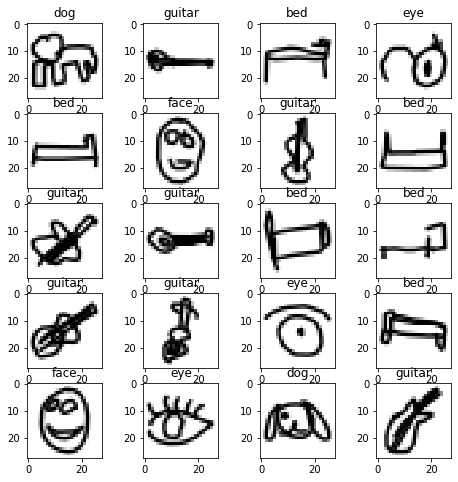

In [4]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])]) 
    plt.imshow(img, cmap="gray")
plt.show()

## Normalization

In [5]:
print("Mean and std of images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Mean and std of images 209.42618 85.55308
Mean and std of scaled images -1.2394183e-09 0.9285714


## Handle dataset
### Create the dataset

In [6]:
# Allow the handle dataset : tf.data.Dataset 
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images)
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

### Iter in dataset

In [7]:
for item in train_dataset:
    print(item.shape)
    break

(28, 28, 1)


In [8]:
# Batch = subset of the entire dataset
# Epoch = when all batch are trained, number of iteration global
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break

(32, 28, 28, 1)


### Create the training dataset - adding targets to images

In [9]:
# Creating tuple : image - target
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))

In [10]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1 
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break

(32, 28, 28, 1) (32,)


# Build a model with the subclassing API

<img src="images/cnn.png" style="height:400px">



In [23]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        # 32 = features map, 4 = size (the smaller, the more it's precise)
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution - Only one layer for all - Transforms cube in array 1 dimension
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(5, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()
model.predict(scaled_images[0:1])

array([[0.189567  , 0.21045981, 0.19719228, 0.20980422, 0.19297673]],
      dtype=float32)

## Set the loss and objectives

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam() # Better than gradient

## Set some metrics to track the progress of the training

In [25]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy - Does my model make good predictions ?
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

## Training method
The train_step method used autograp, compute the gradient to optimize the model and gather the loss and accuracy on the training set

In [26]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

## Validation method
The valid_step function is simply used to test the image on the validation set and to gather the loss and accuracy

In [27]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

# Train and test the model on the validation set

In [28]:
epoch = 10
batch_size = 32
b = 0 # Tracking for batch
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    # Reinitialize validator
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()
    b = 0

# Batch accuracy = 97/98/99% => overfitting

 Batch 5024/5025, Loss: 0.6151700615882874, Accuracy: 78.925369262695314
Epoch 1, Valid Loss: 0.37059667706489563, Valid Accuracy: 87.07070922851562
 Batch 10080/5025, Loss: 0.2479100227355957, Accuracy: 91.62188720703125
Epoch 2, Valid Loss: 0.3549681305885315, Valid Accuracy: 87.9595947265625
 Batch 15136/5025, Loss: 0.1134546622633934, Accuracy: 96.179107666015625
Epoch 3, Valid Loss: 0.41835927963256836, Valid Accuracy: 88.44444274902344
 Batch 20192/5025, Loss: 0.07940748333930969, Accuracy: 97.154228210449228
Epoch 4, Valid Loss: 0.4744608402252197, Valid Accuracy: 88.24242401123047
 Batch 25248/5025, Loss: 0.055650558322668076, Accuracy: 98.06964874267578
Epoch 5, Valid Loss: 0.48245200514793396, Valid Accuracy: 89.53535461425781
 Batch 30304/5025, Loss: 0.029714811593294144, Accuracy: 98.92537689208984

KeyboardInterrupt: 